# Transformer model for recommendation

In this notebook, we implement the Transformer model proposed in the article [Attention Is All You Need](https://arxiv.org/abs/1706.03762). We replicate the implementation done [here](https://www.tensorflow.org/tutorials/text/transformer).

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import math

from keras.models import load_model, Model

## Architecture

In [ ]:
# Nombre de couches du modèle
n_l = 6
# Taille de l'embedding du modèle
n_e = 128
# Dimension du réseau feed-forward
n_ff = 512
# Nombre de têtes du modèle
n_h = 8
drpt_rate = 0.1

# Nombre de valeurs dans le dictionnaire + la valeur vide
d = 14370 + 1 # 1 catégories supplémentaires : une <EOS>
# Taille de l'input
Tx = 64
# Taille de l'output
Ty = 16
# Batch Size
m = 64

The goal of this section is to reproduce the following diagram:
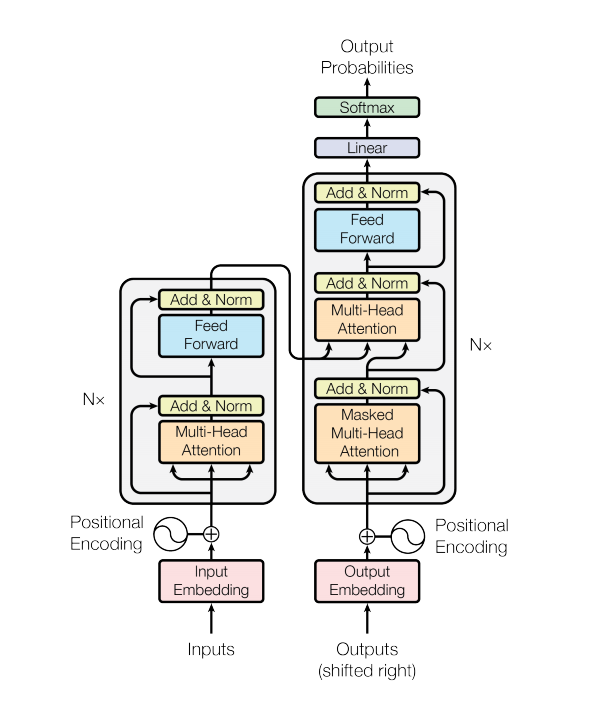

### Positional embeddings

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

### Mask

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

### Dot Product Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

### Multi-head Attention

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model = 512, num_heads = 8, causal=False, dropout=0.0):
    super(MultiHeadAttention, self).__init__()

    assert d_model % num_heads == 0
    depth = d_model // num_heads

    self.w_query = tf.keras.layers.Dense(d_model)
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))

    self.w_value = tf.keras.layers.Dense(d_model)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))

    self.w_key = tf.keras.layers.Dense(d_model)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout)
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))

    self.dense = tf.keras.layers.Dense(d_model)

  def call(self, inputs, mask=None, training=None):
    q = inputs[0]
    v = inputs[1]
    k = inputs[2] if len(inputs) > 2 else v

    query = self.w_query(q)
    query = self.split_reshape_query(query)
    query = self.split_permute_query(query)

    value = self.w_value(v)
    value = self.split_reshape_value(value)
    value = self.split_permute_value(value)

    key = self.w_key(k)
    key = self.split_reshape_key(key)
    key = self.split_permute_key(key)

    if mask is not None:
      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])

    attention = self.attention([query, value, key], mask=mask)
    attention = self.join_permute_attention(attention)
    attention = self.join_reshape_attention(attention)

    x = self.dense(attention)

    return x

### Feed-forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

### Encoder

In [ ]:

class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(EncoderLayer, self).__init__()

    self.multi_head_attention =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention = tf.keras.layers.Dropout(dropout)
    self.add_attention = tf.keras.layers.Add()
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask])
    attention = self.dropout_attention(attention, training = training)
    x = self.add_attention([inputs , attention])
    x = self.layer_norm_attention(x)
    # x = inputs

    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, maximum_position_encoding = 10000, dropout = 0.0):
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    self.pos = positional_encoding(maximum_position_encoding, d_model)

    self.encoder_layers = [ EncoderLayer(d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout) for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, inputs, mask=None, training=None):
    x = self.embedding(inputs)
    # positional encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]

    x = self.dropout(x, training=training)

    #Encoder layer
    embedding_mask = self.embedding.compute_mask(inputs)
    for encoder_layer in self.encoder_layers:
      x = encoder_layer(x, mask = embedding_mask)

    return x

  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)


### Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,  d_model = 512, num_heads = 8, dff = 2048, dropout = 0.0):
    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True)
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)
    self.add_attention1 = tf.keras.layers.Add()
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)
    self.add_attention2 = tf.keras.layers.Add()
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dense2 = tf.keras.layers.Dense(d_model)
    self.dropout_dense = tf.keras.layers.Dropout(dropout)
    self.add_dense = tf.keras.layers.Add()
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)

  def call(self, inputs, mask=None, training=None):
    # print(mask)
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    attention = self.dropout_attention1(attention, training = training)
    x = self.add_attention1([inputs[0] , attention])
    x = self.layer_norm_attention1(x)

    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    attention = self.dropout_attention2(attention, training = training)
    x = self.add_attention1([x , attention])
    x = self.layer_norm_attention1(x)


    ## Feed Forward
    dense = self.dense1(x)
    dense = self.dense2(dense)
    dense = self.dropout_dense(dense, training = training)
    x = self.add_dense([x , dense])
    x = self.layer_norm_dense(x)

    return x

class Decoder(tf.keras.layers.Layer):
  def __init__(self, target_vocab_size, num_layers = 4, d_model = 512, num_heads = 8, dff = 2048, maximum_position_encoding = 10000, dropout = 0.0):
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model, mask_zero=True)
    self.pos = positional_encoding(maximum_position_encoding, d_model)

    self.decoder_layers = [ DecoderLayer(d_model = d_model, num_heads = num_heads, dff = dff, dropout = dropout)  for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, inputs, mask=None, training=None):
    x = self.embedding(inputs[0])
    # positional encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]

    x = self.dropout(x, training=training)

    #Decoder layer
    embedding_mask = self.embedding.compute_mask(inputs[0])
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Comment this out if you want to use the masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

### Transformer model

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

## Model

In [ ]:
input_vocab_size = d
target_vocab_size = d

input = tf.keras.layers.Input(shape=(Tx,))
target = tf.keras.layers.Input(shape=(Ty,))

encoder = Encoder(input_vocab_size, num_layers = n_l, d_model = n_e, num_heads = n_h, dff = n_ff, dropout = drpt_rate)
decoder = Decoder(input_vocab_size, num_layers = n_l, d_model = n_e, num_heads = n_h, dff = n_ff, dropout = drpt_rate)

x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

model = tf.keras.models.Model(inputs=[input, target], outputs=x)

model.summary()

In [ ]:
#model.save("/content/drive/MyDrive/PSC Recommandation séquentielle/Modèles/Attention Network/Transformer_save")

## Data pipeline

In [ ]:
folder = "/content/drive/MyDrive/PSC Recommandation séquentielle/Données/DataTables/"

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self , nb_lines, X_path, Y_path):
    self.X_path = X_path
    self.X_reader = csv.reader(open(folder + X_path , "r"))
    self.Y_path = Y_path
    self.Y_reader = csv.reader(open(folder + Y_path , "r"))
    self.nb_lines = nb_lines

  def __len__(self):
    return math.ceil(self.nb_lines/m)

  def __getitem__(self, idx):
    X1 = []
    X2 = []
    Y = []
    for i in range(m):
      x,y = self.getNextSample()
      x = [int(i) for i in x]
      y = [int(i) for i in y]
      X1.append(x)
      X2.append([0] + y[0:Ty-1])
      Y.append(y)
    X1 = np.array(X1)
    X2 = np.array(X2)
    return [np.array(X1), np.array(X2)] , np.array(Y)

  def getNextSample(self):
    x = next(self.X_reader , None)
    y = next(self.Y_reader , None)
    if x is None:
      self.X_reader = csv.reader(open(folder + self.X_path , "r"))
      self.Y_reader = csv.reader(open(folder + self.Y_path , "r"))
      x = next(self.X_reader , None)
      y = next(self.Y_reader , None)
    return x , y

## Training

### Finding optimal $m$

In [ ]:
model = load_model("/content/drive/MyDrive/PSC Recommandation séquentielle/Modèles/Attention Network/Transformer_save" ,
                   compile = False)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)

def masked_loss(y_true, y_pred):
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)




metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer="Adamax", loss = loss, metrics = metrics) # masked_

In [ ]:
train_gen = DataGenerator(1024 #3705954
                          , "reversed_X_train.csv"
                          ,"Y_train.csv")
model.fit(train_gen , epochs=1, verbose = 1)